In [73]:
# If you run on colab uncomment the following line
#!pip install git+https://github.com/clementchadebec/benchmark_VAE.git

In [1]:
import torch
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2

In [2]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

/home/clement/anaconda3/envs/pythae/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
from pythae.models import VAEGAN, VAEGANConfig
from pythae.trainers import CoupledOptimizerAdversarialTrainer, CoupledOptimizerAdversarialTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_VAE_MNIST, Decoder_AE_MNIST, LayeredDiscriminator_MNIST

In [7]:
config = CoupledOptimizerAdversarialTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    batch_size=100,
    num_epochs=100,
)


model_config = VAEGANConfig(
    input_dim=(1, 28, 28),
    latent_dim=10,
    adversarial_loss_scale=0.8,
    reconstruction_layer= 3,
    margin=0.4,
    equilibrium= 0.68

)

model = VAEGAN(
    model_config=model_config,
    encoder=Encoder_VAE_MNIST(model_config), 
    decoder=Decoder_AE_MNIST(model_config) 
)

In [8]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [9]:
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Coupled Optimizer Adversarial Trainer

Model passed sanity check !

Created my_model/VAEGAN_training_2022-01-11_12-32-49. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/1: 100%|██████████| 100/100 [00:06<00:00, 15.94batch/s, encoder_loss=0.339, decoder_loss=-.426, discriminator_loss=0.74]
----------------------------------------------------------------
Epoch 1: Train loss: 0.5844046989	 Encoder loss: 0.2643819614	 Decoder loss: -0.5387070591	 Discriminator loss: 0.8587297969
Epoch 1: Eval loss: 0.65266752	 Encoder loss: 0.3392184542	 Decoder loss: -0.4261265737	 Discriminator loss: 0.7395756394
----------------------------------------------------------------
----------------------------------
Training ended!
Saved final model in my_model/VAEGAN_training_2022-01-11_12-32-49/final_model


In [10]:
import os

In [11]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = VAEGAN.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [12]:
from pythae.samplers import NormalSampler

In [13]:
# create normal sampler
normal_samper = NormalSampler(
    model=trained_model
)

In [14]:
# sample
gen_data = normal_samper.sample(
    num_samples=25
)

In [15]:
import matplotlib.pyplot as plt

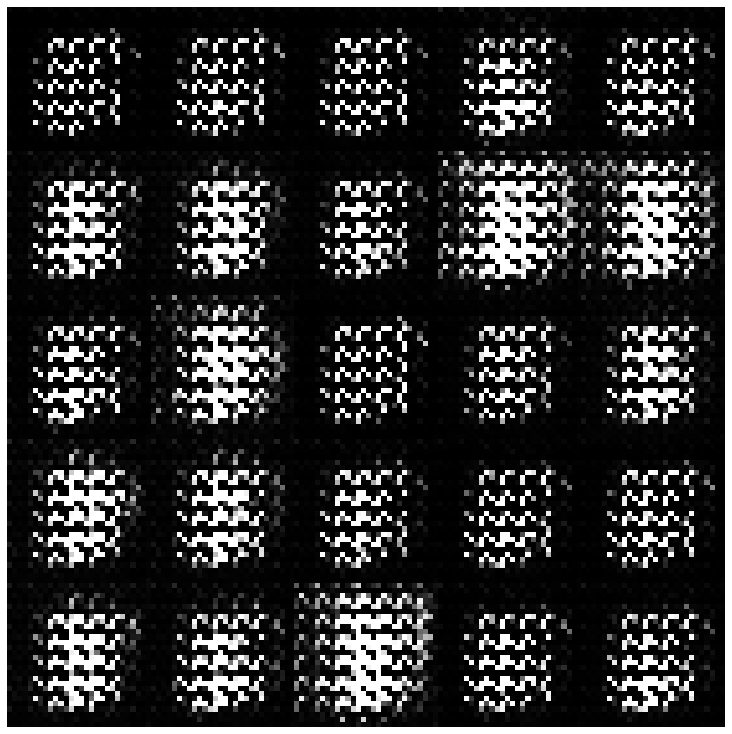

In [16]:
# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [17]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

In [18]:
# set up gmm sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

# fit the sampler
gmm_sampler.fit(train_dataset)

In [19]:
# sample
gen_data = gmm_sampler.sample(
    num_samples=25
)

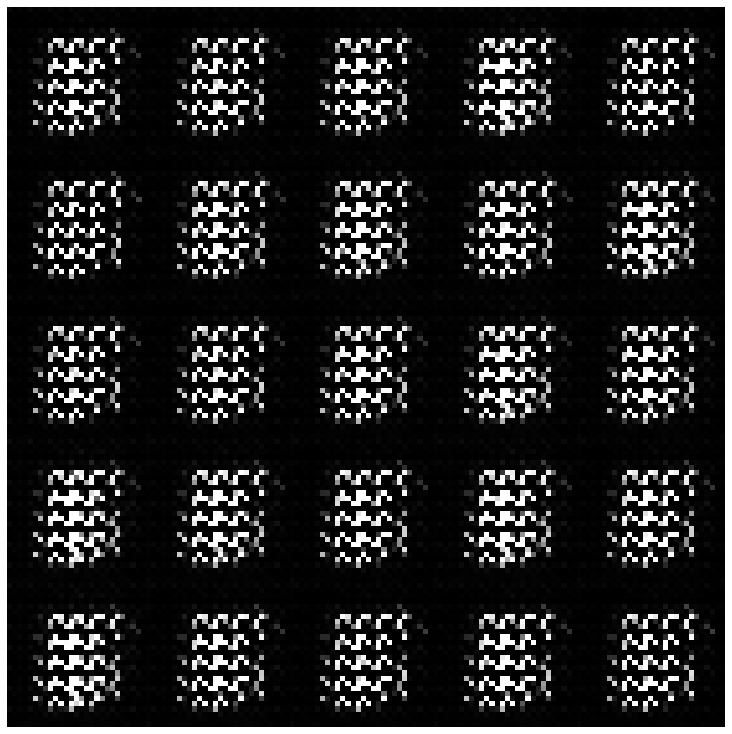

In [20]:
# show results with gmm sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## ... the other samplers work the same